# Отток клиентов

# Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# План выполнения проекта

* Загрузим и подготовим данные.
* Исследуем баланс классов, обучим модель без учёта дисбаланса.
* Улучшим качество модели, учитывая дисбаланс классов. Обучим разные модели и найдем лучшую.
* Проведем финальное тестирование.

# Описание данных

* Признаки:
  * RowNumber — индекс строки в данных
  * CustomerId — уникальный идентификатор клиента
  * Surname — фамилия
  * CreditScore — кредитный рейтинг
  * Geography — страна проживания
  * Gender — пол
  * Age — возраст
  * Tenure — сколько лет человек является клиентом банка
  * Balance — баланс на счёте
  * NumOfProducts — количество продуктов банка, используемых клиентом
  * HasCrCard — наличие кредитной карты
  * IsActiveMember — активность клиента
  * EstimatedSalary — предполагаемая зарплата
* Целевой признак:
  * Exited — факт ухода клиента

# Импорт библиотек

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy
import math
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты на месте
</div>


# Фиксация переменных

In [2]:
RANDOM_STATE = 12345 #Зафиксируем псевдослучайность

## Загрузим и изученим даннные

In [3]:
data_1 = 'Churn.csv'
data_2 = 'https://code.s3.yandex.net/datasets/Churn.csv'

if os.path.exists(data_1):
    сustomer_churn = pd.read_csv(data_1)
elif os.path.exists(data_2):
    сustomer_churn = pd.read_csv(data_2)
else:
    print('Something is wrong')

Выведем первые 10 строчек датафрейма на экран:

In [4]:
сustomer_churn.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Заменим названия столбцов датасета с полу-Camel case на Snake case:

In [5]:
сustomer_churn.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', \
              'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited' ]

Выведем основную информацию о датафрейме с помощью метода info():

In [6]:
сustomer_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Применим метод `describe` чтобы зафиксировать нюансы распределения данных в числах:

In [7]:
сustomer_churn.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Изучив общую информацию о датасете, можно сделать следующие выводы:

* gender и geography нужно перевести в дамми с помощью метода One-Hot Encoding
* обратим внимание на столбец `estimated_salary` — предполагаемая зарплата, минимальное значение `11,58` выглядит подозрительно.

Проверим данные на мультиколлинеарность между признаками:

In [17]:
сustomer_churn_corr = сustomer_churn[['row_number', 'customer_id', 'credit_score', 'age', 'tenure', 'balance', 'num_of_products', \
                'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']]

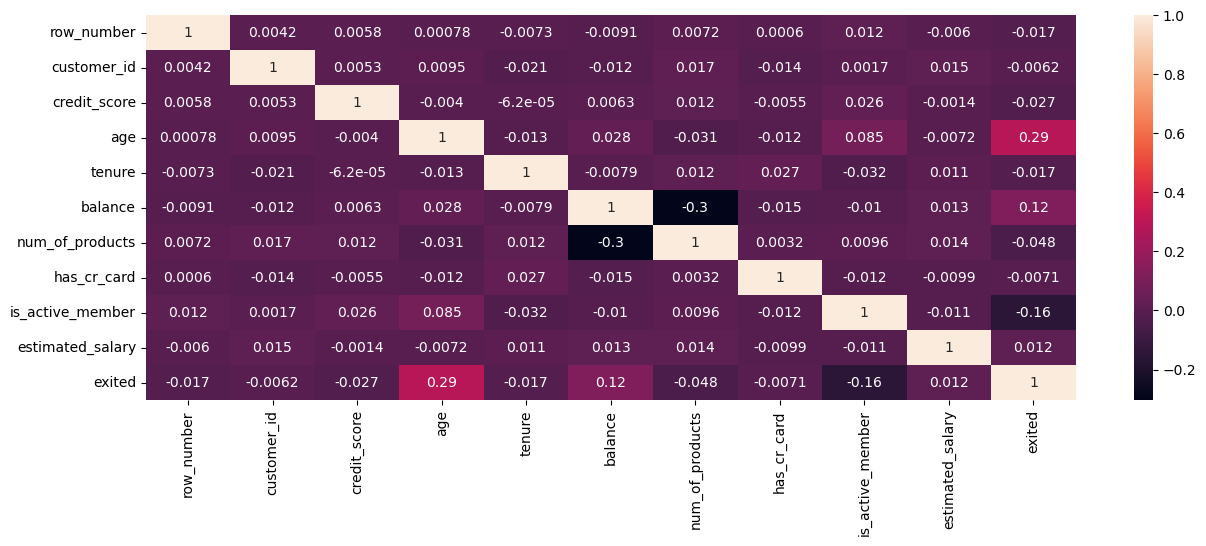

In [18]:
plt.figure(figsize = (15,5))
sns.heatmap(сustomer_churn_corr.corr(), annot = True)
plt.show()

Критично высоких связей между признаками не наблюдается, поэтому можно оставить модель с изначальным набором признаков.

Построим диаграмму распределения для столбца `stimated_salary`, чтобы визуально оценить выбросы.

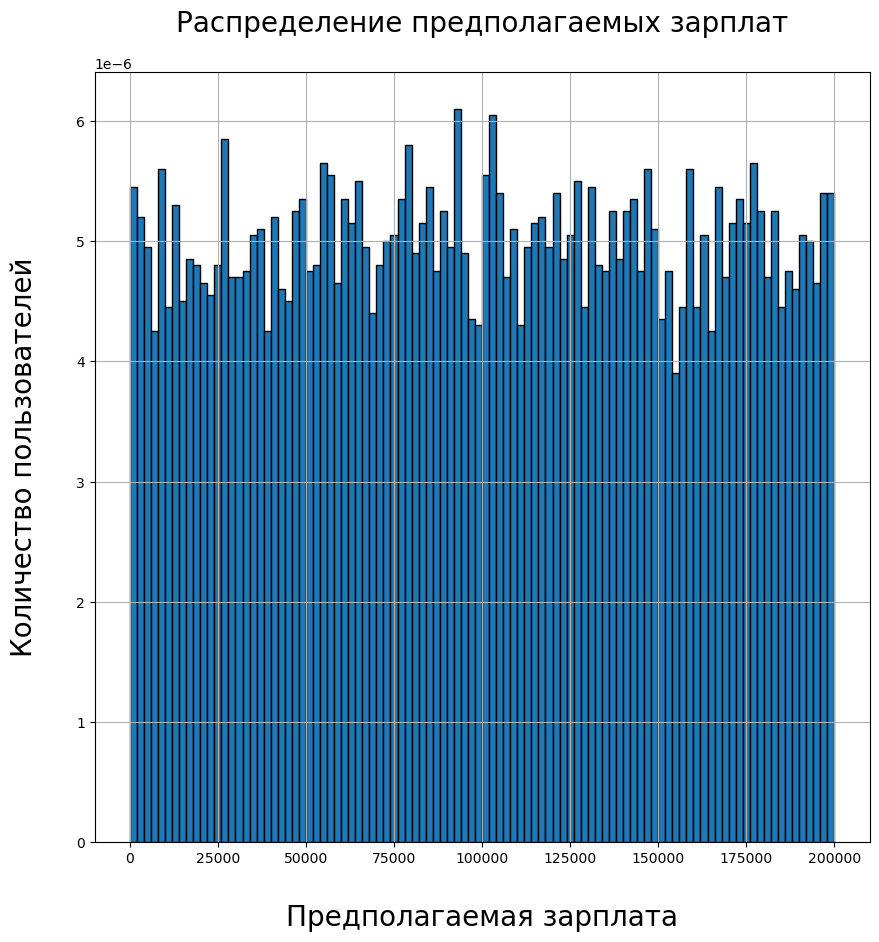

In [19]:
plt.figure(figsize=(10,10))
plt.hist(сustomer_churn['estimated_salary'], bins=100, density=True, edgecolor='black')
plt.title('Распределение предполагаемых зарплат' + "\n", size=20)
plt.xlabel("\n" + 'Предполагаемая зарплата', size=20)
plt.ylabel('Количество пользователей' + "\n", size=20)
plt.grid()
plt.show()

Допустим.

Проверим датасет на наличие пропусков в данных:

In [20]:
сustomer_churn.isna().sum()

row_number            0
customer_id           0
surname               0
credit_score          0
geography             0
gender                0
age                   0
tenure              909
balance               0
num_of_products       0
has_cr_card           0
is_active_member      0
estimated_salary      0
exited                0
dtype: int64

В столбце `tenure` наблюдается 909 прорусков.
Будем считать, что если это пропуск, значит человек не является клиентом банка. Заполним пропуски нулями.

In [21]:
сustomer_churn.tenure = сustomer_churn.tenure.fillna(0)

Проверим:

In [22]:
сustomer_churn.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

### Выводы после загрузки и изучения данных.
По предварительному просмотру основной информации данных можно отметить следующее:

На основании имеющихсф данных о клиентах нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

Соответственно:

* `exited` - это целевой признак
* все остальные столбцы - это признаки, которые влияют на результат классификации

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разобъем в соотношении 3:1:1:

Обучающая выборка (60%);
Валидационная выборка (20%);
Тестовая выборка (20%).

* OHE применим к столбцам gender и geography; 
* Масштабирование - к `credit_score`, `balance` и `estimated_salary`, так как мы не хотим, чтобы при обучении какой-то признак с более высоким значением был засчитан как более значимый.

## Подготовим данные

Посмотрев на основную информацию о признаках, можно сказать, что One-Hot Encoding и масштабирование нужно применить точечно.

Дополнительно проверим уникальные значения для категориальных признаков, чтобы убедиться в том, что OHE к ним применять имеет смысл.

In [23]:
сustomer_churn.gender.unique()

array(['Female', 'Male'], dtype=object)

In [24]:
сustomer_churn.geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [25]:
сustomer_churn = pd.get_dummies(сustomer_churn, drop_first=True, columns=['gender', 'geography'])

In [26]:
сustomer_churn.head()

,row_number,customer_id,surname,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,gender_Male,geography_Germany,geography_Spain
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,False,False,False
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,False,False,True
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,False,False,False
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,False,False,False
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,False,False,True


Проведем масштабирование признаков:

In [27]:
cols_to_scale = ['credit_score', 'balance', 'estimated_salary']

In [28]:
scaler = StandardScaler()
scaler.fit(сustomer_churn[cols_to_scale])

сustomer_churn[cols_to_scale] = scaler.transform(сustomer_churn[cols_to_scale])

Проверим масштабирование признаков:

In [29]:
сustomer_churn.head()

,row_number,customer_id,surname,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,gender_Male,geography_Germany,geography_Spain
0,1,15634602,Hargrave,-0.326221,42,2.0,-1.225848,1,1,1,0.021886,1,False,False,False
1,2,15647311,Hill,-0.440036,41,1.0,0.117350,1,0,1,0.216534,0,False,False,True
2,3,15619304,Onio,-1.536794,42,8.0,1.333053,3,1,0,0.240687,1,False,False,False
3,4,15701354,Boni,0.501521,39,1.0,-1.225848,2,0,0,-0.108918,0,False,False,False
4,5,15737888,Mitchell,2.063884,43,2.0,0.785728,1,1,1,-0.365276,0,False,False,True


Дальше разделим датасет на 3 выборки - обучающую, валидационную и тестовую.
Кроме того, удалим признаки `row_number`, `customer_id` и `surmane` так как они никак не влияют на качество обучения (а если и влияют, то только в негативном ключе).

In [35]:
target = сustomer_churn['exited']
features = сustomer_churn.drop(['exited', 'surname', 'customer_id', 'row_number'], axis=1)

In [36]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.2, 
                                                                            random_state=RANDOM_STATE)

In [38]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train, 
                                                                              target_train, 
                                                                              test_size=0.25, 
                                                                              random_state=RANDOM_STATE)

Проверим размер разбитых выборок:

In [39]:
def check_data_split(splited_df, df = сustomer_churn):
    split_val = round((splited_df.shape[0] / df.shape[0]) * 100, 2)
    return f'Размер данных разбитой выборки от исходных данных составляет: {split_val} %'

In [40]:
check_data_split(target_train)

'Размер данных разбитой выборки от исходных данных составляет: 60.0 %'

In [41]:
check_data_split(target_valid)

'Размер данных разбитой выборки от исходных данных составляет: 20.0 %'

In [42]:
check_data_split(target_test)

'Размер данных разбитой выборки от исходных данных составляет: 20.0 %'

Судя по полученным цифрам, данные разделены на 3 выборки в верном соотношении.

### Вывод после подготовки данных:
* Провели масштабирование признаков;

* Проверили масштабирование признаков;

* Провели разделение исходных данных на обучающую, валидационную и тестовую выборки;

* Проверили корректность разделения данных.

## Исследуем задачу

### Проверка на наличие дисбаланса:

Чтобы оценить адекватность модели, проверим, как часто в целевом признаке встречается класс «1» или «0».

In [43]:
class_frequency = сustomer_churn['exited'].value_counts(normalize=1)

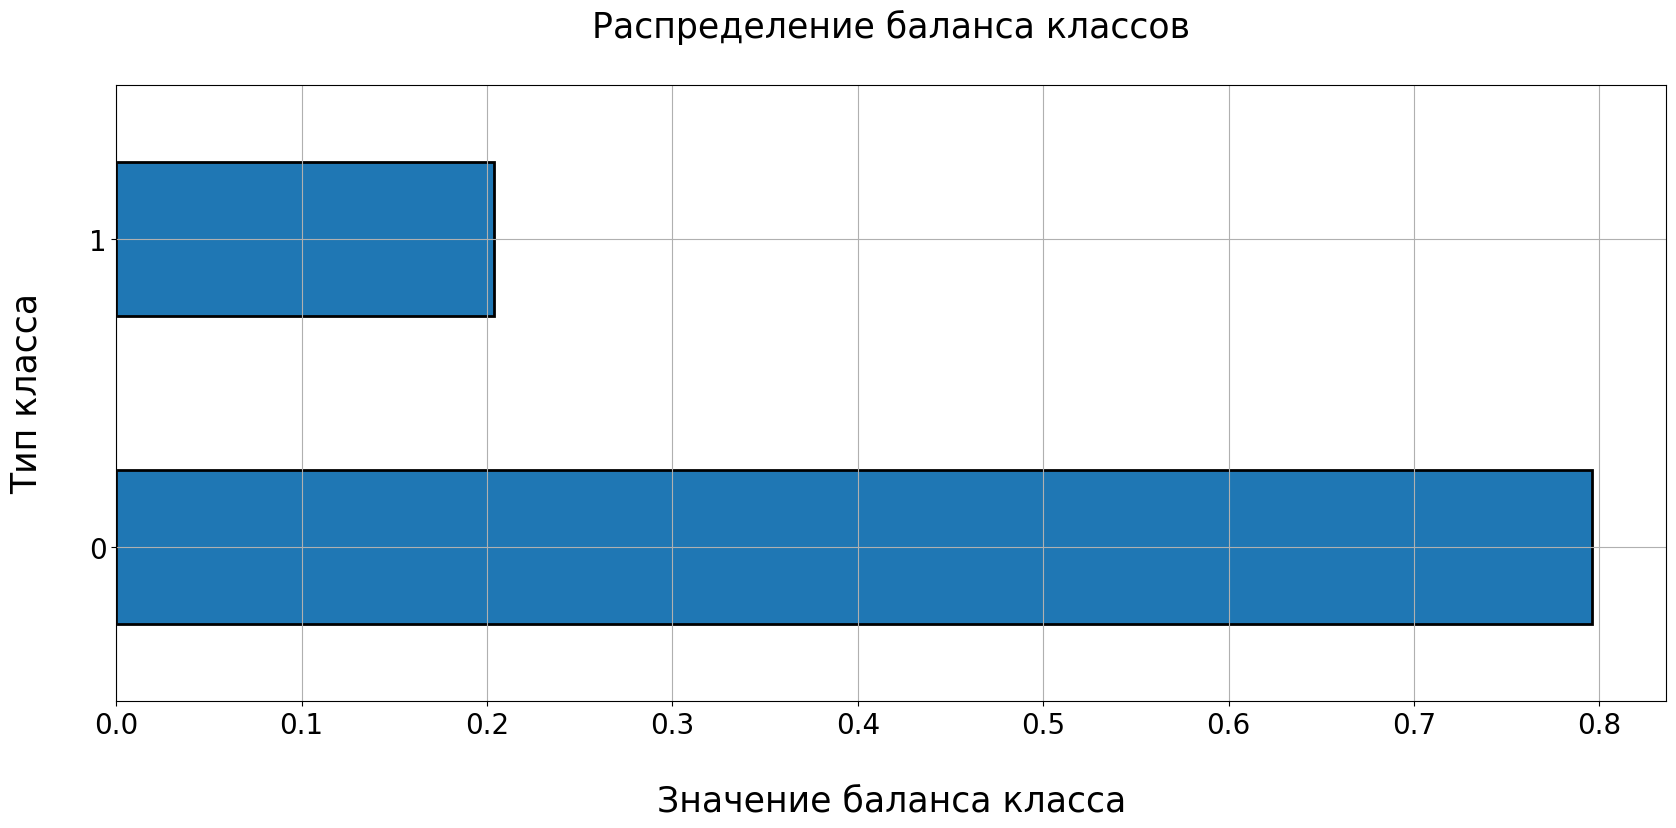

In [44]:
class_frequency.plot(kind = 'barh', 
    figsize = (20,8), 
    edgecolor='black', 
    legend = False, 
    fontsize = 20,
    linewidth = 2
    ).set_title('Распределение баланса классов' + "\n", fontsize = 25);
plt.grid()
plt.xlabel("\n" + 'Значение баланса класса', size=25);
plt.ylabel('Тип класса' + "\n", size = 25);

In [45]:
class_frequency

exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Из полученных данных видно, что в целевом признаке наблюдается достаточно сильный дисбаланс классов - только 20% отражают факт ухода клиента.

Сравним качество предсказаний с константной моделью. За константу примем пример 0, так как это значение встречается почти в 80% случаев.

In [46]:
target_pred_constant = pd.Series([0]*len(target))

In [47]:
accuracy_score(target, target_pred_constant)

0.7963

### Проверим модели без учета дисбаланса

Теперь обучим несколько моделей без учета дисбаланса, и посмотрим на ключевые метрики - `Recall`, `Precision` и `F1-score`.
Перед этим подберем оптимальные гиперпараметры для моделей на основании метрики `F1-score`.

#### Дерево решений

In [48]:
best_model = None
best_f1 = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                        max_depth=depth)
    model_tree.fit(features_train, target_train)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева =', best_depth) 
print('Качество модели - ', f1_tree)

Оптимальная глубина дерева = 7
Качество модели -  0.5321375186846039


In [50]:
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                    max_depth=7)
model_tree.fit(features_train, target_train)
predictions_valid_tree = model_tree.predict(features_valid)

In [51]:
print("Accuracy_tree:", accuracy_score(target_valid, predictions_valid_tree))
print("Recall_tree:", recall_score(target_valid, predictions_valid_tree))
print("Precision_tree:", precision_score(target_valid, predictions_valid_tree))
print("F1_tree:", f1_score(target_valid, predictions_valid_tree))

Accuracy_tree: 0.857
Recall_tree: 0.44501278772378516
Precision_tree: 0.7160493827160493
F1_tree: 0.5488958990536277


#### Случайный лес

In [52]:
best_model = None
for est in range(10, 101, 10):
    for depth in range(1, 10):
        model_forest = RandomForestClassifier(random_state=RANDOM_STATE,
                                              n_estimators=est, 
                                              max_depth=depth)
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Оптимальное количество оценок =', best_est)
print('Оптимальная глубина дерева =', best_depth)
print('Качество модели - ', f1_forest)

Оптимальное количество оценок = 60
Оптимальная глубина дерева = 9
Качество модели -  0.5439469320066335


In [53]:
model_forest = RandomForestClassifier(random_state=RANDOM_STATE, 
                                      n_estimators=60, 
                                      max_depth=9)
model_forest.fit(features_train, target_train)
predictions_valid_forest = model_forest.predict(features_valid)

In [54]:
print("Accuracy_forest:", accuracy_score(target_valid, predictions_valid_forest))
print("Recall_forest:", recall_score(target_valid, predictions_valid_forest))
print("Precision_forest:", precision_score(target_valid, predictions_valid_forest))
print("F1_forest:", f1_score(target_valid, predictions_valid_forest))

Accuracy_forest: 0.8635
Recall_forest: 0.4296675191815857
Precision_forest: 0.7706422018348624
F1_forest: 0.5517241379310345


#### Логистическая регрессия

In [55]:
model_log = LogisticRegression(random_state=RANDOM_STATE,
                               solver='liblinear')

model_log.fit(features_train, target_train)

predictions_valid_log = model_log.predict(features_valid)

In [56]:
print("Accuracy_log:", accuracy_score(target_valid, predictions_valid_log))
print("Recall_log:", recall_score(target_valid, predictions_valid_log))
print("Precision_log:", precision_score(target_valid, predictions_valid_log))
print("F1_log:", f1_score(target_valid, predictions_valid_log))

Accuracy_log: 0.815
Recall_log: 0.2071611253196931
Precision_log: 0.574468085106383
F1_log: 0.30451127819548873


Далее построим матрицу ошибокчтобы посмотреть на соотношения TP, TN, FP и FN и как выглядит дисбаланс классов для 3 обученных моделей.

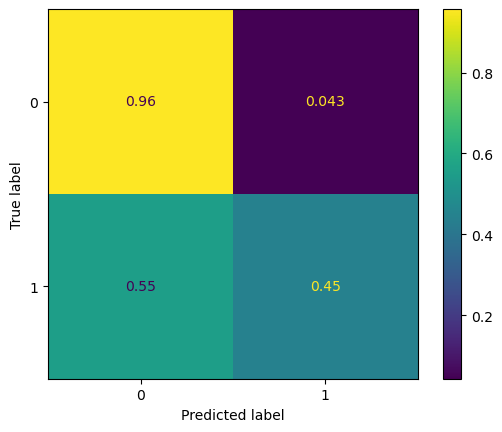

In [57]:
plot_confusion_matrix(estimator=model_tree, X=features_valid, y_true=target_valid,
                      normalize='true');

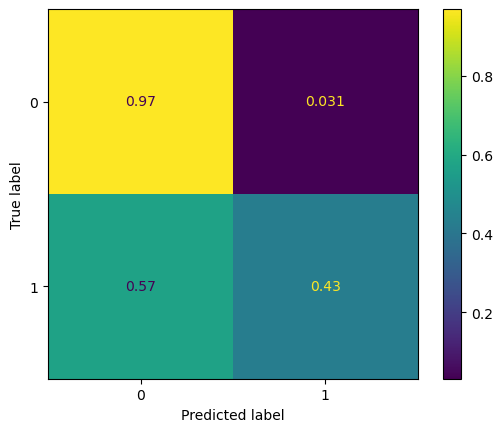

In [58]:
plot_confusion_matrix(estimator=model_forest, X=features_valid, y_true=target_valid,
                      normalize='true');

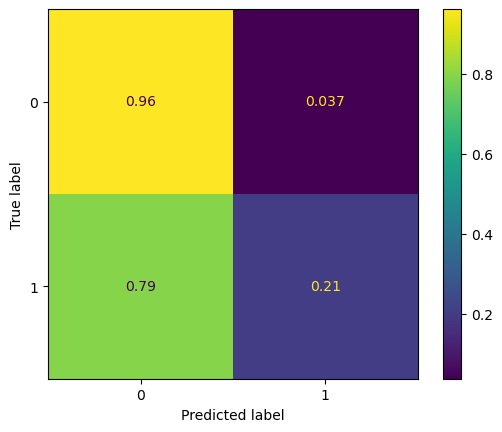

In [59]:
plot_confusion_matrix(estimator=model_log, X=features_valid, y_true=target_valid,
                      normalize='true');

### Вывод после исследования задачи:

Оценим модели по качеству - F1-score:

* Дерево решений:

    * Качество модели = `0.56`;

* Случайный лес:

    * Качество модели = `0.56`;

* Логистическая регрессия:

    * Качество модели = `0.31`.
    
Таким образом, обучив модели без учета дисбаланса классов, наилучшее значение метрики F1-score демонстрирует модель Дерево решений, в то время как наибольшее значение метрики accuracy наблюдается у модели Random Forest.

Матрицы ошибок наглядно демонстрируют то, что несмотря на то, что значение accuracy достаточно высокое, для всех трех моделей наблюдается остаточно сильный дисбаланс классов.

К примеру, для моделей Дерево решений и Случайный лес ситуация схожая - факт того, что клиент не ушел (0), модели определяют правильно примерно в `95`% случаев, в то время как результат предсказаний по факту ухода (1) в среднем всего `45`%.

## Борьба с дисбалансом

Рассмотрим 3 метода борьбы с дисбалансом классов:

* Взвешивание классов
* Увеличение выборки (upsampling)
* Уменьшение выборки (downsampling)

### Взвешивание классов

#### Дерево решений

In [60]:
best_model = None
best_f1 = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                        max_depth=depth,
                                        class_weight='balanced')
    model_tree.fit(features_train, target_train)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева =', best_depth) 
print('Качество модели - ', f1_tree)

Оптимальная глубина дерева = 6
Качество модели -  0.5095669687814702


In [61]:
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                    max_depth=6,
                                    class_weight='balanced')
model_tree.fit(features_train, target_train)
predictions_valid_tree = model_tree.predict(features_valid)

In [62]:
print("Recall_tree:", recall_score(target_valid, predictions_valid_tree))
print("Precision_tree:", precision_score(target_valid, predictions_valid_tree))
print("F1_tree:", f1_score(target_valid, predictions_valid_tree))

probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_tree:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_tree: 0.7033248081841432
Precision_tree: 0.46140939597315433
F1_tree: 0.5572441742654509
ROC-AUC_tree: 0.8063601639753369


#### Случайный лес

In [63]:
best_model = None
for est in range(10, 101, 10):
    for depth in range(1, 10):
        model_forest = RandomForestClassifier(random_state=RANDOM_STATE,
                                              n_estimators=est, 
                                              max_depth=depth,
                                              class_weight='balanced')
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Оптимальное количество оценок =', best_est)
print('Оптимальная глубина дерева =', best_depth)

Оптимальное количество оценок = 100
Оптимальная глубина дерева = 9


In [64]:
model_forest = RandomForestClassifier(random_state=RANDOM_STATE, 
                                      n_estimators=100, 
                                      max_depth=9,
                                      class_weight='balanced')
model_forest.fit(features_train, target_train)
predictions_valid_forest = model_forest.predict(features_valid)

In [65]:
print("Recall_forest:", recall_score(target_valid, predictions_valid_forest))
print("Precision_forest:", precision_score(target_valid, predictions_valid_forest))
print("F1_forest:", f1_score(target_valid, predictions_valid_forest))

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_forest:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_forest: 0.618925831202046
Precision_forest: 0.5601851851851852
F1_forest: 0.5880923450789793
ROC-AUC_forest: 0.8550512701094706


### Логистическая регрессия

In [66]:
model_log = LogisticRegression(random_state=RANDOM_STATE,
                               solver='liblinear',
                               class_weight='balanced')

model_log.fit(features_train, target_train)
predictions_valid_log = model_log.predict(features_valid)

In [67]:
print("Recall_log:", recall_score(target_valid, predictions_valid_log))
print("Precision_log:", precision_score(target_valid, predictions_valid_log))
print("F1_log:", f1_score(target_valid, predictions_valid_log))

probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_log:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_log: 0.6879795396419437
Precision_log: 0.3695054945054945
F1_log: 0.48078641644325293
ROC-AUC_log: 0.7729062387243113


### Увеличение выборки

In [68]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=RANDOM_STATE)
    target_upsampled = shuffle(target_upsampled, random_state=RANDOM_STATE)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9657, 11)
(9657,)


#### Дерево решений

In [69]:
best_model = None
best_f1 = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                        max_depth=depth)
    model_tree.fit(features_upsampled, target_upsampled)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева =', best_depth) 
print('Качество модели - ', f1_tree)

Оптимальная глубина дерева = 6
Качество модели -  0.5060483870967742


In [70]:
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                    max_depth=7)
model_tree.fit(features_upsampled, target_upsampled)
predictions_valid_tree = model_tree.predict(features_valid)

In [71]:
print("Recall_tree:", recall_score(target_valid, predictions_valid_tree))
print("Precision_tree:", precision_score(target_valid, predictions_valid_tree))
print("F1_tree:", f1_score(target_valid, predictions_valid_tree))

probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_tree:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_tree: 0.6956521739130435
Precision_tree: 0.45714285714285713
F1_tree: 0.5517241379310345
ROC-AUC_tree: 0.7980111870727161


#### Случайный лес

In [72]:
best_model = None
for est in range(10, 101, 10):
    for depth in range(1, 10):
        model_forest = RandomForestClassifier(random_state=RANDOM_STATE,
                                              n_estimators=est, 
                                              max_depth=depth)
        model_forest.fit(features_upsampled, target_upsampled)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Оптимальное количество оценок =', best_est)
print('Оптимальная глубина дерева =', best_depth)

Оптимальное количество оценок = 100
Оптимальная глубина дерева = 9


In [73]:
model_forest = RandomForestClassifier(random_state=RANDOM_STATE, 
                                      n_estimators=10, 
                                      max_depth=9)
model_forest.fit(features_upsampled, target_upsampled)
predictions_valid_forest = model_forest.predict(features_valid)

In [74]:
print("Recall_forest:", recall_score(target_valid, predictions_valid_forest))
print("Precision_forest:", precision_score(target_valid, predictions_valid_forest))
print("F1_forest:", f1_score(target_valid, predictions_valid_forest))

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_forest:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_forest: 0.6649616368286445
Precision_forest: 0.4914933837429111
F1_forest: 0.5652173913043478
ROC-AUC_forest: 0.842788884137977


#### Логистическая регрессия

In [75]:
model_log = LogisticRegression(random_state=RANDOM_STATE,
                               solver='liblinear')
model_log.fit(features_upsampled, target_upsampled)
predictions_valid_log = model_log.predict(features_valid)

In [76]:
print("Recall_log:", recall_score(target_valid, predictions_valid_log))
print("Precision_log:", precision_score(target_valid, predictions_valid_log))
print("F1_log:", f1_score(target_valid, predictions_valid_log))

probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_log:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_log: 0.6930946291560103
Precision_log: 0.363758389261745
F1_log: 0.4771126760563381
ROC-AUC_log: 0.7730063787614108


### Уменьшение выборки

In [77]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] +
                                   [target_ones])
    
    features_downsampled = shuffle(features_downsampled, random_state=RANDOM_STATE)
    target_downsampled = shuffle(target_downsampled, random_state=RANDOM_STATE)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2414, 11)
(2414,)


#### Дерево решений

In [78]:
best_model = None
best_f1 = 0
for depth in range(1, 10):
    model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                        max_depth=depth)
    model_tree.fit(features_downsampled, target_downsampled)
    predictions_valid_tree = model_tree.predict(features_valid)
    f1_tree = f1_score(target_valid, predictions_valid_tree)
    if f1_tree > best_f1:
        best_model = model_tree
        best_depth = depth
        best_f1 = f1_tree

print('Оптимальная глубина дерева =', best_depth) 
print('Качество модели - ', f1_tree)

Оптимальная глубина дерева = 7
Качество модели -  0.5014031805425632


In [79]:
model_tree = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                    max_depth=7)
model_tree.fit(features_downsampled, target_downsampled)
predictions_valid_tree = model_tree.predict(features_valid)

In [80]:
print("Recall_tree:", recall_score(target_valid, predictions_valid_tree))
print("Precision_tree:", precision_score(target_valid, predictions_valid_tree))
print("F1_tree:", f1_score(target_valid, predictions_valid_tree))

probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_tree:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_tree: 0.7519181585677749
Precision_tree: 0.4298245614035088
F1_tree: 0.5469767441860465
ROC-AUC_tree: 0.8160244723176378


#### Случайный лес

In [81]:
best_model = None
for est in range(10, 101, 10):
    for depth in range(1, 10):
        model_forest = RandomForestClassifier(random_state=RANDOM_STATE,
                                              n_estimators=est, 
                                              max_depth=depth)
        model_forest.fit(features_downsampled, target_downsampled)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Оптимальное количество оценок =', best_est)
print('Оптимальная глубина дерева =', best_depth)

Оптимальное количество оценок = 100
Оптимальная глубина дерева = 9


In [82]:
model_forest = RandomForestClassifier(random_state=RANDOM_STATE, 
                                      n_estimators=10, 
                                      max_depth=9)
model_forest.fit(features_downsampled, target_downsampled)
predictions_valid_forest = model_forest.predict(features_valid)

In [83]:
print("Recall_forest:", recall_score(target_valid, predictions_valid_forest))
print("Precision_forest:", precision_score(target_valid, predictions_valid_forest))
print("F1_forest:", f1_score(target_valid, predictions_valid_forest))

probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_forest:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_forest: 0.7289002557544757
Precision_forest: 0.45893719806763283
F1_forest: 0.5632411067193676
ROC-AUC_forest: 0.8370395743889472


#### Логистическая регрессия

In [84]:
model_log = LogisticRegression(random_state=RANDOM_STATE,
                               solver='liblinear')

model_log.fit(features_downsampled, target_downsampled)
predictions_valid_log = model_log.predict(features_valid)

In [85]:
print("Recall_log:", recall_score(target_valid, predictions_valid_log))
print("Precision_log:", precision_score(target_valid, predictions_valid_log))
print("F1_log:", f1_score(target_valid, predictions_valid_log))

probabilities_valid = model_log.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("ROC-AUC_log:", roc_auc_score(target_valid, probabilities_one_valid))

Recall_log: 0.6982097186700768
Precision_log: 0.3620689655172414
F1_log: 0.47685589519650656
ROC-AUC_log: 0.7738202152533942


### Выводы после борьбы с дисбалансом:

In [90]:
model_name = ['Tree', 'Forest', 'Log']
initial_values = [0.548, 0.551, 0.304]
weighting_values = [0.557, 0.588, 0.481]
down_values = [0.551, 0.565, 0.477]
up_values = [0.546, 0.563, 0.476]

df_metrics = pd.DataFrame({'Model Name': model_name,
                           'Initial': initial_values,
                           'Weighing': weighting_values,
                           'Downsampling': down_values,
                           'Upsampling': up_values })

In [91]:
df_metrics

,Model Name,Initial,Weighing,Downsampling,Upsampling
0,Tree,0.548,0.557,0.551,0.546
1,Forest,0.551,0.588,0.565,0.563
2,Log,0.304,0.481,0.477,0.476


* Уменьшение и увеличение выборки позволяют достичь примерно одинаковое значение F1-score.
* Наибольшее значение метрики F1-score получено на модели Случайный лес при помощи взвешивания классов. Поэтому для тестирования будем использовать эту модель.
* Значение метрики AUC-ROC всегда стабильно выше F1-score и колеблется в районе 80%.

## Тестирование модели

Перед тестированием объединим валидационную и тестовую выборки, чтобы качество было выше.

In [92]:
new_features_test = pd.concat([features_test, features_valid], axis=0, ignore_index=True)
new_target_test = pd.concat([target_test, target_valid], axis=0, ignore_index=True)

In [93]:
check_data_split(new_target_test)

'Размер данных разбитой выборки от исходных данных составляет: 40.0 %'

In [94]:
best_model = None
for est in range(10, 101, 10):
    for depth in range(1, 10):
        model_forest = RandomForestClassifier(random_state=RANDOM_STATE,
                                              n_estimators=est, 
                                              max_depth=depth,
                                              class_weight='balanced')
        model_forest.fit(features_train, target_train)
        predictions_valid_forest = model_forest.predict(features_valid)
        f1_forest = f1_score(target_valid, predictions_valid_forest)
        if f1_forest > best_f1:
            best_model = model_forest
            best_est = est
            best_depth = depth

print('Оптимальное количество оценок =', best_est)
print('Оптимальная глубина дерева =', best_depth)

Оптимальное количество оценок = 100
Оптимальная глубина дерева = 9


In [95]:
model_forest = RandomForestClassifier(random_state=RANDOM_STATE, 
                                      n_estimators=100, 
                                      max_depth=9,
                                      class_weight='balanced')
model_forest.fit(features_train, target_train)
predictions_test_forest = model_forest.predict(new_features_test)

In [96]:
print("Recall_forest:", recall_score(new_target_test, predictions_test_forest))
print("Precision_forest:", precision_score(new_target_test, predictions_test_forest))
print("F1_tree:", f1_score(new_target_test, predictions_test_forest))

probabilities_test = model_forest.predict_proba(new_features_test)
probabilities_one_test = probabilities_test[:, 1]
print("ROC-AUC_forest:", roc_auc_score(new_target_test, probabilities_one_test))

Recall_forest: 0.636919315403423
Precision_forest: 0.5900339750849377
F1_tree: 0.612580834803057
ROC-AUC_forest: 0.8611751001584401


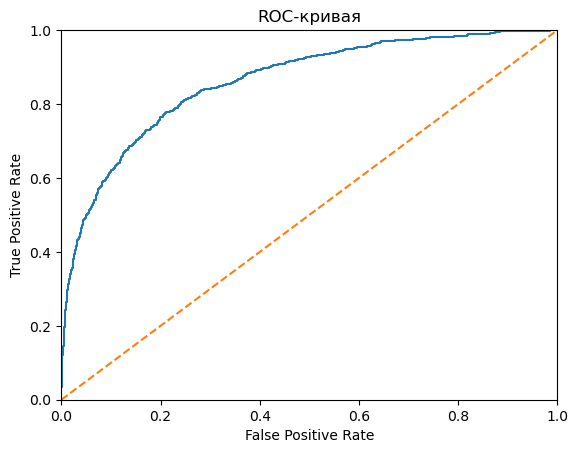

In [97]:
fpr, tpr, thresholds = roc_curve(new_target_test, probabilities_one_test) 

plt.figure()
plt.plot(fpr, tpr, linestyle='solid')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Общий вывод:

Была проведена предварительная подготовка датасета, а именно:

* Заполнены пропуски в данных;
* Удалены два категориальных столбца `сustomer_id` и `surname` + `row_number`, так как они никак не влияют на качество обучения (а если и влияют, то только в негативном ключе);
* Дополнительно проведена проверка на наличие сильной мультиколлинеарность (подтвердилось ее отстутствие);
* Два категориальных признака (`gender`, `geography`) были преобразованы в бинарные при помощи техники One-Hot Ecnoding
* К трем количественным признакам (`credit_score`, `balance` и `estimated_salary`) было применено масштабирование, чтобы при обучении не получилось так, что какой-то признак с более высоким значением был засчитан как более значимый.

Проверка датасета на наличие дисбаланса показала, что в целевом признаке наблюдается достаточно сильный дисбаланс классов - только 20% отражают факт ухода клиента:



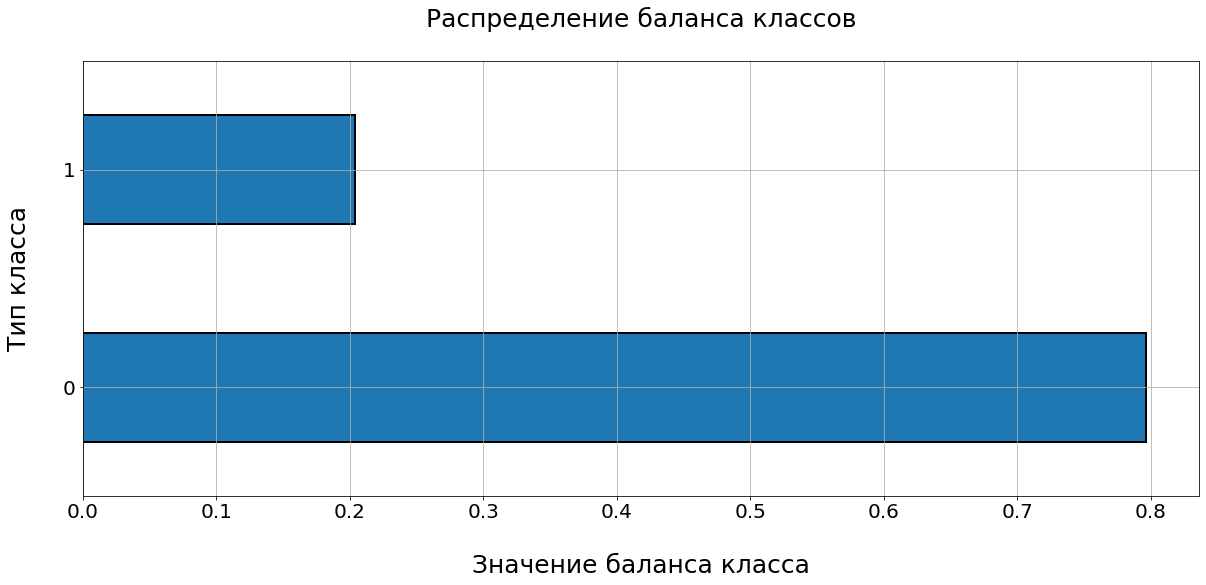

С помощью матриц ошибок можно явно увидеть, что несмотря на достаточно высокое значение accuracy, для всех трех моделей наблюдается остаточно сильный дисбаланс классов. К примеру, для моделей Дерево решений и Случайный лес ситуация схожая - факт того, что клиент не ушел (0), модели определяют правильно примерно в 95% случаев, в то время как результат предсказаний по факту ухода (1) в среднем всего 45%.

В рамках борьбы с дисбалансом классов было рассмотрено 3 метода:

* Взвешивание классов;
* Увеличение выборки (upsampling);
* Уменьшение выборки (downsampling);
* Значения метрики F1-score, полученные на разных этапах исследования:

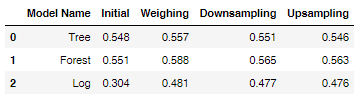

В результате борьбы с дисбанансом классов были получены следующие выводы:

* Уменьшение и увеличение выборки позволяют достичь примерно одинаковое значение F1-score.
* Наибольшее значение метрики F1-score получено на модели Случайный лес при помощи взвешивания классов. Поэтому для финального тестирования была использована именно она.
* Значение метрики AUC-ROC всегда стабильно выше F1-score и колеблется в районе 80%.

Далее, наилучшая модель была протестирована на тестовой выборке.
Значения ключевых метрик получились следующие:

* F1-score = 0.612 (выше необходимого значения);
* AUC-ROC = 0.861 (достаточно близко к единице).

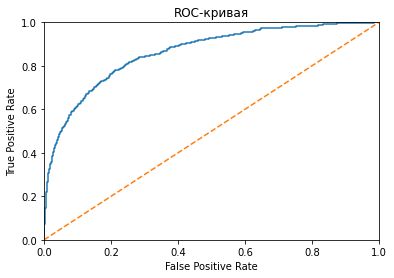